In [1]:
!pip install pip3-autoremove -q
!pip install -q torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu124
!pip install unsloth -q
!pip install --upgrade -q transformers==4.53.2 "huggingface_hub>=0.34.0" "datasets>=3.4.1,<4.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import pandas as pd
import numpy as np
import unsloth
import torch
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, load_dataset
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import FastLanguageModel
from trl import SFTTrainer
from unsloth.chat_templates import get_chat_template

# Configuration
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
VER = 1
model_name ="unsloth/Qwen2.5-Math-1.5B-bnb-4bit"
EPOCHS = 1
DIR = f"ver_{VER}"
os.makedirs(DIR, exist_ok=True)
MAX_LEN = 2048

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-08-21 06:36:23.518825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755758183.853196      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755758183.947542      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
train = pd.read_csv("/kaggle/input/map-charting-student-math-misunderstandings/train.csv")
test = pd.read_csv("/kaggle/input/map-charting-student-math-misunderstandings/test.csv")

In [4]:
train.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NaN
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NaN
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NaN
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NaN
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NaN


In [5]:
train.isna().sum()

row_id                    0
QuestionId                0
QuestionText              0
MC_Answer                 0
StudentExplanation        0
Category                  0
Misconception         26836
dtype: int64

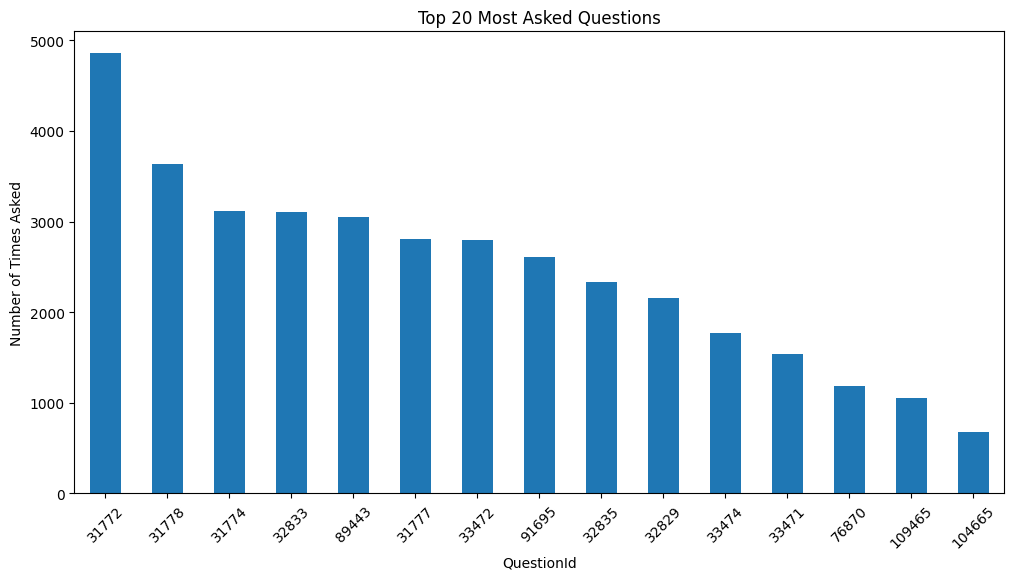

In [6]:
import matplotlib.pyplot as plt

# Count frequency of each QuestionId
question_counts = train["QuestionId"].value_counts()

# Plot the top 20 most asked questions
plt.figure(figsize=(12,6))
question_counts.head(20).plot(kind='bar')

plt.title("Top 20 Most Asked Questions")
plt.xlabel("QuestionId")
plt.ylabel("Number of Times Asked")
plt.xticks(rotation=45)
plt.show()


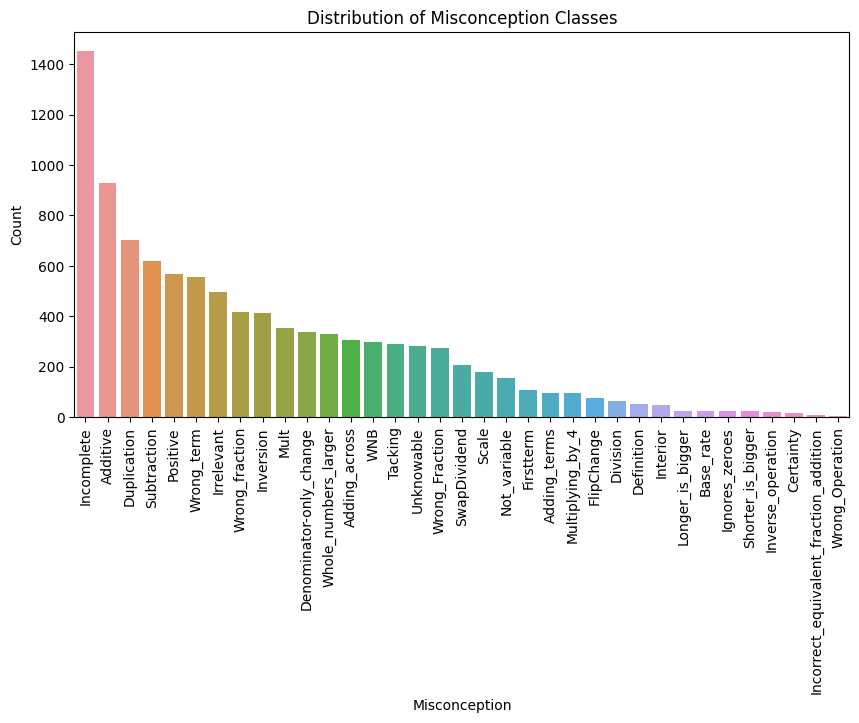

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count values of Misconception (dropna because many are missing)
miscon_counts = train['Misconception'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x=miscon_counts.index, y=miscon_counts.values)
plt.xticks(rotation=90)
plt.title("Distribution of Misconception Classes")
plt.ylabel("Count")
plt.show()


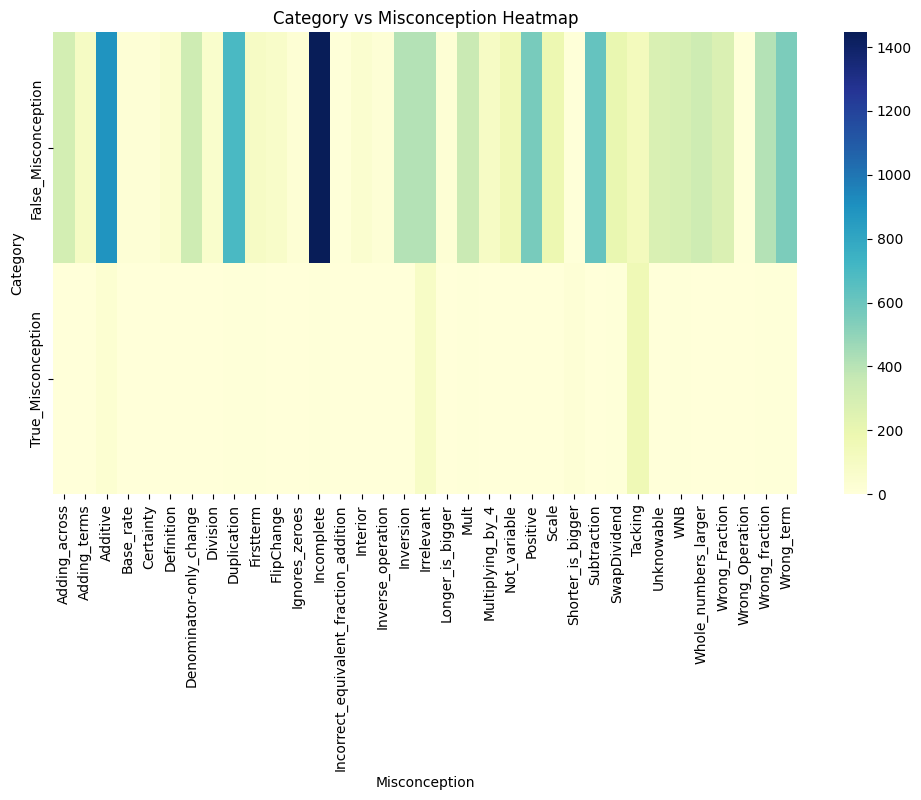

In [8]:
# Cross-tabulation
crosstab = pd.crosstab(train['Category'], train['Misconception'])

plt.figure(figsize=(12,6))
sns.heatmap(crosstab, annot=False, cmap="YlGnBu")
plt.title("Category vs Misconception Heatmap")
plt.show()


In [9]:
# Number of unique questions
num_questions = train["QuestionId"].nunique()
print("Number of unique questions:", num_questions)


Number of unique questions: 15


In [10]:
# Count how many student explanations per Question
question_counts = train["QuestionId"].value_counts()

print("Top 5 questions with MOST student explanations:\n", question_counts.head())
print("\nTop 5 questions with LEAST student explanations:\n", question_counts.tail())


Top 5 questions with MOST student explanations:
 QuestionId
31772    4857
31778    3640
31774    3115
32833    3105
89443    3054
Name: count, dtype: int64

Top 5 questions with LEAST student explanations:
 QuestionId
33474     1766
33471     1542
76870     1186
109465    1051
104665     673
Name: count, dtype: int64


In [11]:
# Load data

le = LabelEncoder()
train['Misconception'] = train['Misconception'].fillna('NA')
train['target'] = train['Category'] + ':' + train['Misconception']
train['label'] = le.fit_transform(train['target'])
num_labels = len(le.classes_)

# --- Create 'is_correct' feature (same logic as inference notebook) ---
idx = train.apply(lambda row: row.Category.split('_')[0], axis=1) == 'True'
correct = train.loc[idx].copy()
correct['c'] = correct.groupby(['QuestionId', 'MC_Answer']).MC_Answer.transform('count')
correct = correct.sort_values('c', ascending=False).drop_duplicates(['QuestionId'])
correct = correct[['QuestionId', 'MC_Answer']].assign(is_correct=1)
train = train.merge(correct, on=['QuestionId', 'MC_Answer'], how='left')
train['is_correct'] = train['is_correct'].fillna(0)

# --- Format input text ---
def format_input(row):
    x = "This answer is correct." if row['is_correct'] else "This answer is incorrect."
    return (
        f"Question: {row['QuestionText']}\n"
        f"Answer: {row['MC_Answer']}\n"
        f"{x}\n"
        f"Student Explanation: {row['StudentExplanation']}"
    )
train['text'] = train.apply(format_input, axis=1)

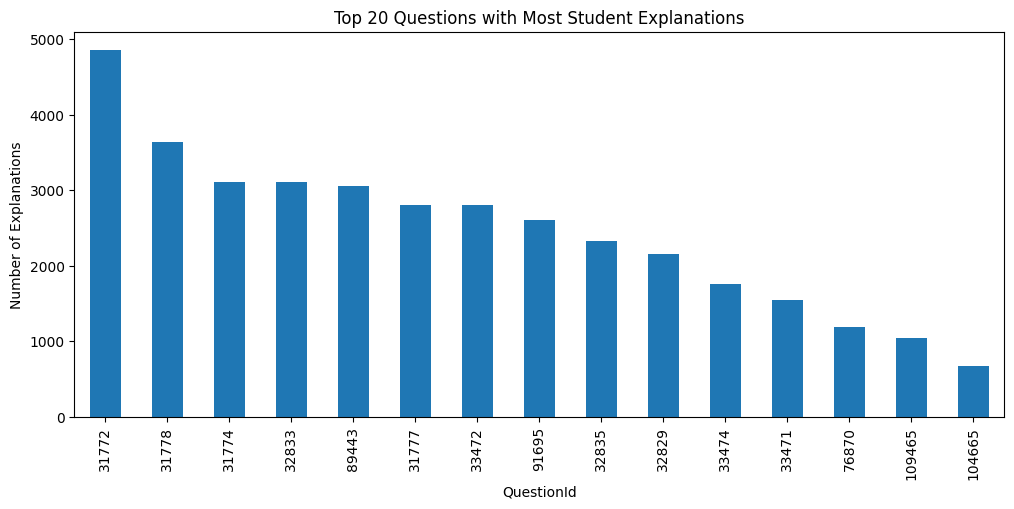

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
question_counts.head(20).plot(kind='bar')
plt.title("Top 20 Questions with Most Student Explanations")
plt.xlabel("QuestionId")
plt.ylabel("Number of Explanations")
plt.show()


In [13]:
# Number of unique misconceptions per question
misconception_per_q = train.groupby("QuestionId")["Misconception"].nunique()
print(misconception_per_q)
print(misconception_per_q.describe())  # summary stats

# Example: show top questions with most misconceptions
print(misconception_per_q.sort_values(ascending=False).head(10))


QuestionId
31772     3
31774     4
31777     4
31778     4
32829     4
32833     4
32835     5
33471     3
33472     4
33474     3
76870     4
89443     3
91695     3
104665    3
109465    3
Name: Misconception, dtype: int64
count    15.000000
mean      3.600000
std       0.632456
min       3.000000
25%       3.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: Misconception, dtype: float64
QuestionId
32835    5
31777    4
31774    4
32829    4
31778    4
32833    4
33472    4
76870    4
31772    3
33471    3
Name: Misconception, dtype: int64


In [14]:
train.dtypes

row_id                  int64
QuestionId              int64
QuestionText           object
MC_Answer              object
StudentExplanation     object
Category               object
Misconception          object
target                 object
label                   int64
is_correct            float64
text                   object
dtype: object

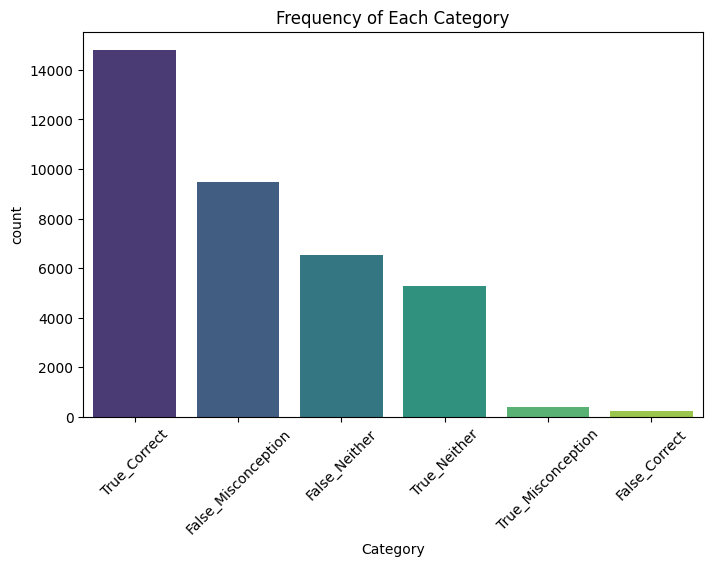

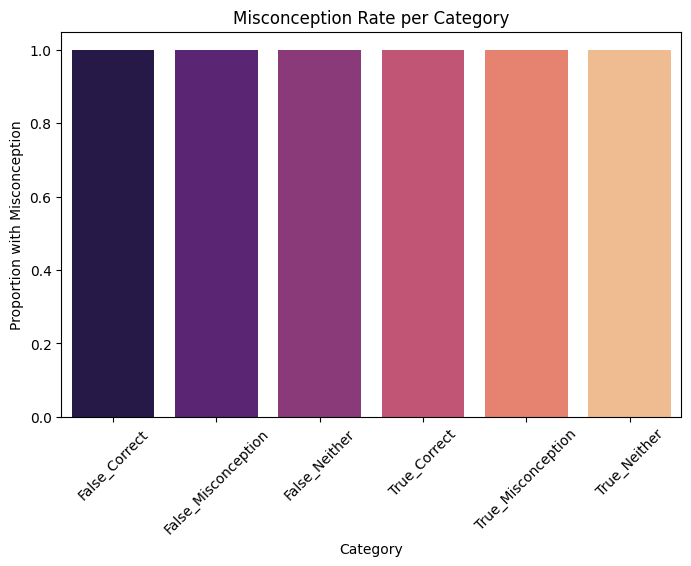

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Frequency of each Category
plt.figure(figsize=(8,5))
sns.countplot(data=train, x="Category", order=train["Category"].value_counts().index, palette="viridis")
plt.title("Frequency of Each Category")
plt.xticks(rotation=45)
plt.show()

# Misconception rate per Category
misconception_rate = train.groupby("Category")["Misconception"].apply(lambda x: (x != "None").mean())
plt.figure(figsize=(8,5))
sns.barplot(x=misconception_rate.index, y=misconception_rate.values, palette="magma")
plt.title("Misconception Rate per Category")
plt.ylabel("Proportion with Misconception")
plt.xticks(rotation=45)
plt.show()


In [16]:
num = train["label"].nunique()
num

65

In [17]:
test = test.merge(correct, on=['QuestionId','MC_Answer'], how='left')
test.is_correct = test.is_correct.fillna(0)
test

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,is_correct
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",1.0
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,0.0
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,1.0


In [18]:
def format_input(row):
    x = "This answer is correct."
    if not row['is_correct']:
        x = "This is answer is incorrect."
    return (
        f"Question: {row['QuestionText']}\n"
        f"Answer: {row['MC_Answer']}\n"
        f"{x}\n"
        f"Student Explanation: {row['StudentExplanation']}"
    )

test['text'] = test.apply(format_input,axis=1)
test

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,is_correct,text
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",1.0,Question: What fraction of the shape is not sh...
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,0.0,Question: What fraction of the shape is not sh...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,1.0,Question: Which number is the greatest?\nAnswe...


In [19]:
special_character_list = [
    '■', '□', '▲', '△', '▼', '▽', '◆', '◇', '○', '●', '★', '☆', '♦', '♥', '♠', '♣',
    '§', '†', '‡', '※', '∞', '±', '≠', '≈', '√', '∑', '∏', '∆', 'Ω', 'μ', '∂', '→',
    '←', '↑', '↓', '↔', '↕', '〈', '〉', '『', '』', '│', '─', '┌', '┐', '└', '┘', '┼',
    '█', '▓', '▒', '£', '¥', '€', '₩', '©', '®', '™', '♪', '♫', '☀', '☁', '☂', '☃', '☎'
]

# Map the integer label to its corresponding special character
train['special_label'] = train['label'].apply(lambda x: special_character_list[int(x)])

In [20]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    max_seq_length=MAX_LEN,
    dtype=None,
    load_in_4bit=True,
)

# Prepare the model for LoRA fine-tuning
model = FastLanguageModel.get_peft_model(
    model,
    r=8, # Increased rank for better learning
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=64,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=42,
    use_rslora=False,
    loftq_config=None,
)

==((====))==  Unsloth 2025.8.9: Fast Qwen2 patching. Transformers: 4.53.2.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/165 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Unsloth 2025.8.9 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [21]:
n_classes = len(le.classes_)


In [22]:
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "qwen2.5", # Using standard qwen2 chat template
)
class_mappings = [f"{special_character_list[i]}: {le.classes_[i]}" for i in range(n_classes)]

In [23]:
SYS_PROMPT = f"""You are an expert at analyzing math student responses. Your task is to classify the student's explanation into one of the following Category:Misconception classes.

Respond with ONLY the single character corresponding to the correct classification.

Available classifications:
{', '.join(class_mappings)}

Analyze the given input and provide your classification.
"""

# Create user prompt
user_prompt_template = """Question: {QuestionText}
Answer: {MC_Answer}
Correct? {CorrectFlag}
Student Explanation: {StudentExplanation}
"""

dataset_chat = [
    [
        {"role": "system", "content": SYS_PROMPT},
        {
            "role": "user",
            "content": user_prompt_template.format(
                QuestionText=row["QuestionText"],
                MC_Answer=row["MC_Answer"],
                CorrectFlag=row["is_correct"],
                StudentExplanation=row["StudentExplanation"],
            )
        },
        {
            "role": "assistant",
            "content": row["special_label"]
        }
    ]
    for _, row in train.iterrows()
]

# Convert to tokenized dataset
def formatting_prompts_func(dataset):
    # This function is now simplified as we handle the chat template application directly.
    texts = [
        tokenizer.apply_chat_template(
            ex, tokenize=False, add_generation_prompt=False
        ) for ex in dataset
    ]
    return {"text": texts}

dataset_tokenized = formatting_prompts_func(dataset_chat)

In [24]:
dataset_tokenized = Dataset.from_dict(dataset_tokenized)


In [25]:
from unsloth import is_bfloat16_supported

training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    warmup_ratio=0.05,
    # num_train_epochs=EPOCHS,
    learning_rate=2e-4,
    fp16=not is_bfloat16_supported(),
    bf16=is_bfloat16_supported(),
    logging_steps=1,
    optim="paged_adamw_8bit",
    weight_decay=0.01,
    lr_scheduler_type="linear",
    seed=42,
    output_dir=f"./{DIR}",
    # save_strategy="epoch",
    save_strategy="steps",
    save_steps=0.10,
    max_steps = 50,
    save_total_limit=5,
    report_to="none",
)

In [26]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset_tokenized,
    dataset_text_field="text",
    max_seq_length=MAX_LEN,
    dataset_num_proc=2,
    packing=False, # Important for classification tasks
    args=training_args,
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/36696 [00:00<?, ? examples/s]

In [27]:
from unsloth.chat_templates import train_on_responses_only

trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|im_start|>user\n",
    response_part = "<|im_start|>assistant\n",
)

Map (num_proc=4):   0%|          | 0/36696 [00:00<?, ? examples/s]

In [28]:
trainer_stats = trainer.train()


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 36,696 | Num Epochs = 1 | Total steps = 50
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 9,232,384 of 1,552,946,688 (0.59% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,9.222700
2,9.293700
3,9.049800
4,8.903400
5,7.730300
6,7.324900
7,6.071600
8,4.592400
9,5.408100
10,5.312400


In [29]:
save_dir = "./finetuned_model"
trainer.model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)


('./finetuned_model/tokenizer_config.json',
 './finetuned_model/special_tokens_map.json',
 './finetuned_model/chat_template.jinja',
 './finetuned_model/vocab.json',
 './finetuned_model/merges.txt',
 './finetuned_model/added_tokens.json',
 './finetuned_model/tokenizer.json')

In [30]:
import shutil

shutil.make_archive("finetuned_model", "zip", "./finetuned_model")


'/kaggle/working/finetuned_model.zip'